In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib.colors import LinearSegmentedColormap
import os
import ast

In [2]:
master_data_path = "../Data/Goodreads_Comics_Data/Data_Files/Masterdata_ongoing.xlsx"
master_data = pd.read_excel(master_data_path, sheet_name=["BOOK_SHEET", "BOOK_REVIEW_SHEET"])

In [3]:
review_num_df = master_data["BOOK_REVIEW_SHEET"]
review_num_df.head()

,book_id,review_num,review_num_en
0,1,79,58
1,2,28,26
2,3,72,61
3,4,62,46
4,5,48,35


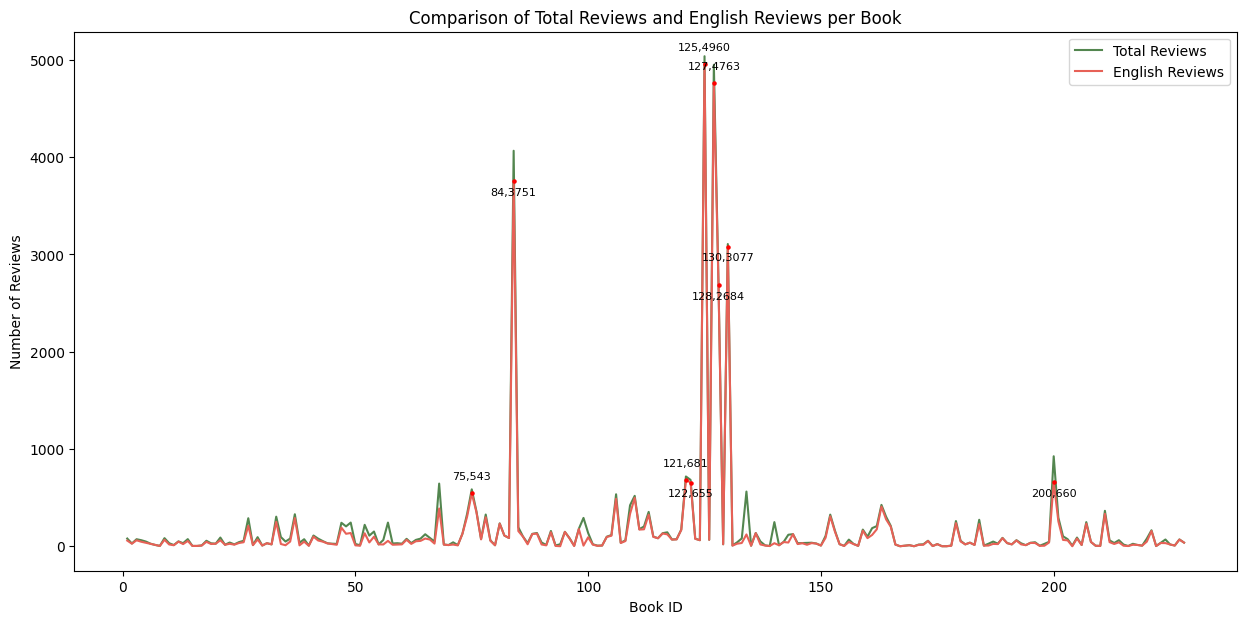

In [4]:
x = review_num_df['book_id']
y_total = review_num_df['review_num']
y_en = review_num_df['review_num_en']

plt.figure(figsize=(15, 7))

plt.plot(x, y_total, label='Total Reviews', color = "#53864F")
plt.plot(x, y_en, label='English Reviews', color = "#E76157")

for i in range(len(y_en)):
    if y_en[i] > 500:
        offset = 10 if i % 2 == 0 else -10  # adjust the position of the text
        plt.annotate(f'{x[i]},{y_en[i]}', (x[i], y_en[i]), textcoords="offset points", xytext=(0, offset), ha='center', fontsize=8)
        plt.scatter(x[i], y_en[i], color='red', s=5, zorder=3)  # mark the point red

plt.xlabel('Book ID')
plt.ylabel('Number of Reviews')
plt.title('Comparison of Total Reviews and English Reviews per Book')
plt.legend()
plt.show()

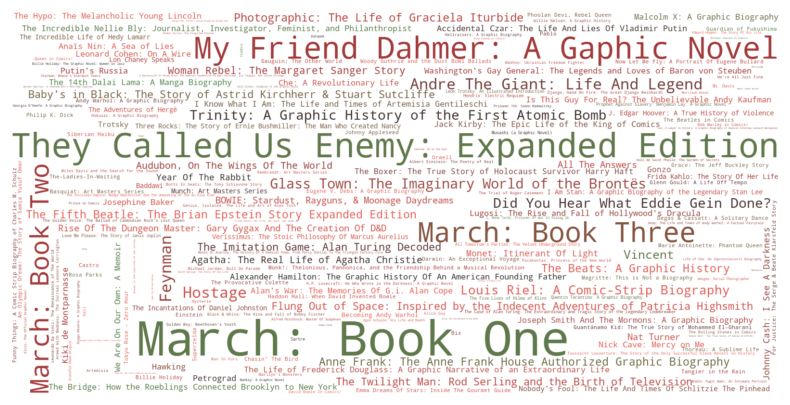

In [10]:
# from matplotlib.colors import LinearSegmentedColormap


colors = ["#2B2B2B", "#E76157", "#A03A3A", "#53864F"]

# Convert the colors to a gradual colormap
cmap = LinearSegmentedColormap.from_list("custom_gradient", colors)

# Merge datasets
merged_df = pd.merge(master_data['BOOK_SHEET'], review_num_df, on='book_id')

# Create a dictionary of book titles and their corresponding English review numbers
title_review_dict = dict(zip(merged_df['title'], merged_df['review_num_en']))

wordcloud = WordCloud(width=1600, height=800, background_color='white', colormap=cmap).generate_from_frequencies(title_review_dict)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
# plt.title('Word Cloud of Book Titles Based on English Review Numbers')
plt.show()

In [36]:
# Bubble chart for most frequent tags
# X: number of books that the tag appears in
# Y: mean rating of reviews with the tag
# Bubble size: tag frequency over the whole dataset
# Bubble color: tag category

# import os

tag_counter_path = "../Data/Tags/tag_counter.csv"
fulltag_df = pd.read_csv(tag_counter_path)
tag_df = fulltag_df[fulltag_df["frequency"] > 100]

en_reviews_path = "../Data/Reviews_Scraped/En/"
files = os.listdir(en_reviews_path)
df_list = []
for f in files:
    df = pd.read_csv(en_reviews_path + f)
    df["goodreads_id"] = os.path.basename(f).split("_reviews.csv")[0]
    df_list.append(df)
en_reviews_df = pd.concat(df_list)

en_reviews_df["shelves"] = en_reviews_df["shelves"].apply(ast.literal_eval)
en_reviews_df.head()

/var/folders/d6/hvwxst9x071_r1dtcr9krndr0000gn/T/ipykernel_57547/3404753260.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  en_reviews_df = pd.concat(df_list)


,user_name,user_url,rating,date,text,likes,shelves,lang,word_count,goodreads_id
0,s.penkevich,https://www.goodreads.com/user/show/6431467-s-...,4.0,"June 14, 2023",As inspiring an icon of fashion and personalit...,118,"[art, biography, graphic_novel]",en,757,61783881-frida-kahlo
1,Rebecca,https://www.goodreads.com/user/show/5875398-re...,3.0,"April 27, 2023",De la Mora imagines Kahlo 19071954 hosting a p...,6,"[2023-release, biographical, childrens-or-ya]",en,211,61783881-frida-kahlo
2,Lesley,https://www.goodreads.com/user/show/30099998-l...,3.0,"September 2, 2023",Anything Frida is worthwhile. The art was grea...,0,[],en,13,61783881-frida-kahlo
3,Blanca HM,https://www.goodreads.com/user/show/88893138-b...,5.0,"September 2, 2023",A great way to learn about a great artistI tru...,0,"[art, biography, graphic-novel]",en,248,61783881-frida-kahlo
4,Smitha,https://www.goodreads.com/user/show/7972805-sm...,5.0,"September 5, 2023",This is a beautiful graphic novel that illustr...,0,[],en,131,61783881-frida-kahlo


In [40]:
print(en_reviews_df["shelves"].apply(type).value_counts())
print(en_reviews_df["rating"].apply(type).value_counts())

shelves
<class 'list'>    37212
Name: count, dtype: int64
rating
<class 'float'>    37212
Name: count, dtype: int64


In [41]:
en_reviews_df = en_reviews_df.dropna(subset=['rating'])
len(en_reviews_df)

36035

In [37]:
len(set(en_reviews_df['goodreads_id']))

222

In [42]:
tag_df["bookcount"] = 0
tag_df["mean_rating"] = 0.0

for index, row in tag_df.iterrows():
    tag = row["tag"]
    bookcount = 0
    reviewcount = 0
    rating_sum = 0.0
    unique_goodreads_ids = set()
    for i, r in en_reviews_df.iterrows():
        if tag in r["shelves"] and r["goodreads_id"] not in unique_goodreads_ids:
            unique_goodreads_ids.add(r["goodreads_id"])
            bookcount += 1
        if tag in r["shelves"]:
            reviewcount += 1
            rating_sum += r["rating"]
    mean_rating = rating_sum / reviewcount if reviewcount > 0 else 0
    tag_df.at[index, "bookcount"] = bookcount
    tag_df.at[index, "mean_rating"] = mean_rating

tag_df.head()

/var/folders/d6/hvwxst9x071_r1dtcr9krndr0000gn/T/ipykernel_57547/1290941459.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tag_df["bookcount"] = 0
/var/folders/d6/hvwxst9x071_r1dtcr9krndr0000gn/T/ipykernel_57547/1290941459.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tag_df["mean_rating"] = 0.0


,tag,frequency,bookcount,mean_rating
0,graphic-novels,3023,164,4.112952
1,graphic-novel,2348,165,4.131911
2,biography,1394,150,3.981050
3,non-fiction,1124,124,4.049405
4,comics,1061,155,3.962500


In [44]:
tag_df["mean_rating"] = tag_df["mean_rating"].round(4)
tag_100_path = "../Data/Tags/tag_100_4ACH.csv"
tag_df.to_csv(tag_100_path, index=False)

/var/folders/d6/hvwxst9x071_r1dtcr9krndr0000gn/T/ipykernel_57547/383919592.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tag_df["mean_rating"] = tag_df["mean_rating"].round(4)


In [46]:
tag_df = pd.read_csv(tag_100_path)


In [ ]:
import plotly.express as px

plot_df = tag_df[tag_df["frequency"] > 270]

# Create bubble chart
fig = px.scatter(plot_df, x="bookcount", y="mean_rating", size="frequency", color="group", size_max=60)  # 等比放大气泡的最大尺寸

# label the tags
for i, row in plot_df.iterrows():
    fig.add_annotation(
        x=row['bookcount'],
        y=row['mean_rating'],
        text=row['tag'],
        showarrow=True,
        arrowhead=2,
        ax=0,
        ay=-10,
        font=dict(size=8),  # smaller text size
        yshift=10 if i % 2 == 0 else -10  # avoid overlap
    )

# more compact layout
fig.update_layout(
    xaxis=dict(
        range=[plot_df["bookcount"].min() - 5, plot_df["bookcount"].max() + 5],
        dtick=10  # adjust the interval of x-axis
    ),
    margin=dict(l=20, r=20, t=20, b=20)
)

fig.show()


In [62]:
periodical_path = "../Data/Tags/tag_embedding_maxsim.csv"
periodical_df = pd.read_csv(periodical_path)

periodical_df = periodical_df.drop(columns=['embedding', "similarity"])
periodical_df.head()

,tag,frequency,max_similarity
0,graphic-novels,3023,0.6515
1,graphic-novel,2348,0.6200
2,biography,1394,0.7077
3,non-fiction,1124,0.6912
4,comics,1061,0.8046


In [70]:
similar_df = periodical_df[periodical_df["max_similarity"] > 0.80]
similar_df = similar_df.sort_values("frequency", ascending=False)
# pd.options.display.max_rows = None
# display(similar_df)
pd.options.display.max_rows = 7
similar_df

,tag,frequency,max_similarity
4,comics,1061,0.8046
6,nonfiction,851,0.8070
8,favorites,364,0.8804
...,...,...,...
3528,fluffy,1,0.8406
3543,us,1,0.8234
6480,caribbean,1,0.8522


In [71]:
mannual_path = "../Data/Tags/tag_80maxsim_mannual.csv"
similar_df.to_csv(mannual_path, index=False)

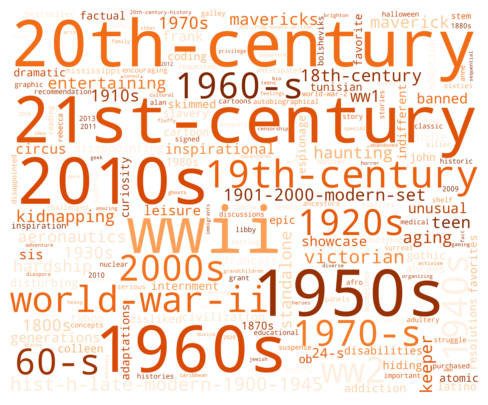

In [78]:
# Find the highest max_similarity value that is less than 1
highest_max_similarity_less_than_1 = similar_df[similar_df["max_similarity"] < 1]["max_similarity"].max()

# Update max_similarity values of 1 to the highest max_similarity value that is less than 1
similar_df.loc[similar_df["max_similarity"] == 1, "max_similarity"] = highest_max_similarity_less_than_1

# Create a dictionary with tags and their updated max_similarity values
tag_similarity_dict = dict(zip(similar_df['tag'], similar_df['max_similarity']))

# Generate the word cloud
wordcloud = WordCloud(width=3650, height=3000, background_color='white', colormap="Oranges").generate_from_frequencies(tag_similarity_dict)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()